## Protein Classfication

## Imports

In [1]:
import textwrap
import random

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import torch
from torch.nn import Linear, Sequential, BatchNorm1d, ReLU, Dropout, Module

import torch_geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool, global_add_pool, GATConv

## Setup

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
SEED = 8225

In [4]:
def seed() -> None:
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    random.seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch_geometric.seed_everything(SEED)

In [5]:
seed()

In [6]:
def plot_acc_and_loss(train_loss, train_acc, val_loss, val_acc):
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    axs[0].plot(train_loss, label='Train')
    axs[0].plot(val_loss, label='Validation')
    axs[0].set_title('Loss')
    axs[0].legend()

    axs[1].plot(train_acc, label='Train')
    axs[1].plot(val_acc, label='Validation')
    axs[1].set_title('Accuracy')
    axs[1].legend()

    plt.show()

## Load the PROTEIN dataset

In [7]:
dataset = TUDataset(root='.', name='PROTEINS')

In [8]:
print(f'Number of graphs: {len(dataset)}')
print(f'Shape: {dataset[0].x.shape}') # (number of nodes, number of node features)
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1113
Shape: torch.Size([42, 3])
Number of classes: 2


In [9]:
dataset[69]

Data(edge_index=[2, 90], x=[26, 3], y=[1])

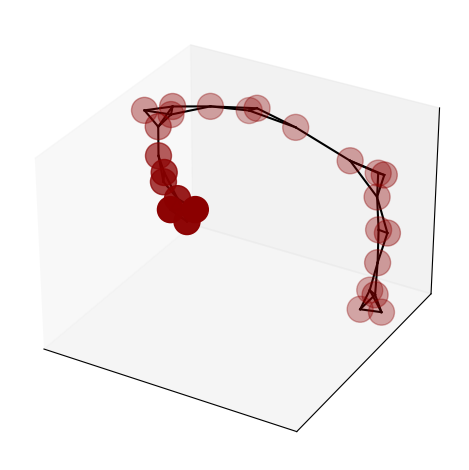

In [10]:
graph = to_networkx(dataset[69], to_undirected=True)

# 3D spring layout
pos = nx.spring_layout(graph, dim=3, seed=SEED)

# Extract node and edge positions from the layout
node_xyz = np.array([pos[v] for v in sorted(graph)])
edge_xyz = np.array([(pos[u], pos[v]) for u, v in graph.edges()])

# Create the 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
for dim in (ax.xaxis, ax.yaxis, ax.zaxis): dim.set_ticks([])

# Plot the nodes - alpha is scaled by "depth" automatically
ax.scatter(*node_xyz.T, s=350, c="darkred")

# Plot the edges
for vizedge in edge_xyz:
    ax.plot(*vizedge.T, color="black")

fig.tight_layout()
plt.savefig('graph.png')
plt.show()

## Prepare data

In [11]:
BATCH_SIZE = 64

In [12]:
def create_data_loader(dataset, batch_size = BATCH_SIZE):
    seed()
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [13]:
seed()
dataset = dataset.shuffle()
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.8, 0.1, 0.1])
print(f"train_dataset: {len(train_dataset)}, val_dataset: {len(val_dataset)}, test_dataset: {len(test_dataset)}")

train_dataset: 891, val_dataset: 111, test_dataset: 111


In [14]:
train_loader = create_data_loader(train_dataset)
val_loader = create_data_loader(val_dataset)
test_loader = create_data_loader(test_dataset)

for name, train_dataloader in zip(('Train', 'Validation', 'Test'), (train_loader, val_loader, test_loader)):
    print(f'{name} loader:')
    for i, subgraph in enumerate(train_dataloader):
        print(f' - Subgraph {i}: {subgraph}')

Train loader:
 - Subgraph 0: DataBatch(edge_index=[2, 9770], x=[2626, 3], y=[64], batch=[2626], ptr=[65])
 - Subgraph 1: DataBatch(edge_index=[2, 9294], x=[2516, 3], y=[64], batch=[2516], ptr=[65])
 - Subgraph 2: DataBatch(edge_index=[2, 9032], x=[2324, 3], y=[64], batch=[2324], ptr=[65])
 - Subgraph 3: DataBatch(edge_index=[2, 11208], x=[3014, 3], y=[64], batch=[3014], ptr=[65])
 - Subgraph 4: DataBatch(edge_index=[2, 9516], x=[2561, 3], y=[64], batch=[2561], ptr=[65])
 - Subgraph 5: DataBatch(edge_index=[2, 9882], x=[2699, 3], y=[64], batch=[2699], ptr=[65])
 - Subgraph 6: DataBatch(edge_index=[2, 10530], x=[2866, 3], y=[64], batch=[2866], ptr=[65])
 - Subgraph 7: DataBatch(edge_index=[2, 9202], x=[2480, 3], y=[64], batch=[2480], ptr=[65])
 - Subgraph 8: DataBatch(edge_index=[2, 7290], x=[1911, 3], y=[64], batch=[1911], ptr=[65])
 - Subgraph 9: DataBatch(edge_index=[2, 9250], x=[2471, 3], y=[64], batch=[2471], ptr=[65])
 - Subgraph 10: DataBatch(edge_index=[2, 8842], x=[2314, 3], y=[

## Model Architecture

In [15]:
class GraphConvolutionalNetwork(Module):
    def __init__(self, hidden_channels, num_node_features, dropout_rate=0.5):
        super(GraphConvolutionalNetwork, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_channels)
        self.bn1 = BatchNorm1d(hidden_channels)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.bn2 = BatchNorm1d(hidden_channels)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.bn3 = BatchNorm1d(hidden_channels)

        self.conv4 = GCNConv(hidden_channels, hidden_channels)
        self.bn4 = BatchNorm1d(hidden_channels)

        self.conv5 = GCNConv(hidden_channels, hidden_channels)
        self.bn5 = BatchNorm1d(hidden_channels)

        self.lin = Linear(hidden_channels, 1)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch) -> torch.Tensor:
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = x.relu()

        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = x.relu()

        x = self.conv5(x, edge_index)
        x = self.bn5(x)
        x = x.relu()

        x = global_mean_pool(x, batch)
        x = self.lin(x)
        x = torch.flatten(x)
        
        return torch.nn.functional.sigmoid(x)

In [16]:
class GraphIsomorphismNetwork(Module):
    def __init__(self, hidden_channels, num_node_features, dropout_rate=0.5):
        super(GraphIsomorphismNetwork, self).__init__()
        self.conv1 = GINConv(
            Sequential(
                Linear(num_node_features, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv2 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv3 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.conv4 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))

        self.conv5 = GINConv(
            Sequential(
                Linear(hidden_channels, hidden_channels), 
                BatchNorm1d(hidden_channels), 
                ReLU(), 
                Linear(hidden_channels, hidden_channels),
                ReLU()
                ))
        
        self.lin1 = Linear(hidden_channels*5, hidden_channels*5)
        self.lin2 = Linear(hidden_channels*5, 1)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch) -> torch.Tensor:
        h1 = self.conv1(x, edge_index)
        h1 = self.dropout(h1)

        h2 = self.conv2(h1, edge_index)
        h2 = self.dropout(h2)

        h3 = self.conv3(h2, edge_index)
        
        h4 = self.conv4(h3, edge_index)

        h5 = self.conv5(h4, edge_index)


        h1 = global_add_pool(h1, batch)
        h2 = global_add_pool(h2, batch)
        h3 = global_add_pool(h3, batch)
        h4 = global_add_pool(h4, batch)
        h5 = global_add_pool(h5, batch)

        h = torch.cat([h1, h2, h3, h4, h5], dim=1)

        h = self.lin1(h).relu()
        h = self.dropout(h)
        h = self.lin2(h)
        h = torch.flatten(h)

        return torch.nn.functional.sigmoid(h)



In [17]:
class GraphAttentionNetwork(Module):
    def __init__(self, hidden_channels, num_node_features, dropout_rate=0.5):
        super(GraphAttentionNetwork, self).__init__()
        self.conv1 = GATConv(num_node_features, hidden_channels, heads=8, dropout=dropout_rate)
        self.bn1 = BatchNorm1d(hidden_channels*8)

        self.conv2 = GATConv(hidden_channels*8, hidden_channels, heads=8, dropout=dropout_rate)
        self.bn2 = BatchNorm1d(hidden_channels*8)

        self.conv3 = GATConv(hidden_channels*8, hidden_channels, heads=8, dropout=dropout_rate)
        self.bn3 = BatchNorm1d(hidden_channels*8)

        self.conv4 = GATConv(hidden_channels*8, hidden_channels, heads=8, dropout=dropout_rate)
        self.bn4 = BatchNorm1d(hidden_channels*8)

        self.conv5 = GATConv(hidden_channels*8, hidden_channels, heads=8, dropout=dropout_rate)
        self.bn5 = BatchNorm1d(hidden_channels*8)

        self.lin1 = Linear(hidden_channels*8, hidden_channels)
        self.lin2 = Linear(hidden_channels, 1)
        self.dropout = Dropout(dropout_rate)

    def forward(self, x, edge_index, batch) ->  torch.Tensor:
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = x.relu()
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = x.relu()

        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = x.relu()

        x = self.conv5(x, edge_index)
        x = self.bn5(x)
        x = x.relu()

        x = global_mean_pool(x, batch)
        x = self.lin1(x)
        x = x.relu()
        x = self.lin2(x)
        x = torch.flatten(x)
        
        return torch.nn.functional.sigmoid(x)

## Training

In [18]:
def accuracy(pred_y, y): 
    return (pred_y > 0.5).eq(y).sum().item() / y.shape[0]

In [19]:
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-2
N_EPOCHS = 100
N_HIDDEN = 256

In [20]:
def evaluate(model: Module, dataloader: DataLoader, device: torch.device) -> tuple[float, float]:
    criterion = torch.nn.CrossEntropyLoss()
    model.eval()
    total_loss = 0
    total_acc = 0

    model = model.to(device)
    for data in dataloader:
      data = data.to(device)
      target = data.y.float()
      prediction = model(data.x, data.edge_index, data.batch)
      loss = criterion(prediction, target)
      total_loss += loss / len(data) / len(dataloader)
      total_acc += accuracy(prediction, target) / len(dataloader)

    return total_loss, total_acc

In [21]:
def train(model: Module, train_dataloader: DataLoader, val_dataloader: DataLoader, device: torch.device) -> Module:
    seed()
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=WEIGHT_DECAY
    )
    model = model.to(device)
    best_val_acc = 0
    best_epoch = 0
    all_val_acc = []
    al_train_acc = []
    all_val_loss = []
    all_train_loss = []
    for epoch in range(1, N_EPOCHS+1):
        total_loss = 0
        acc = 0
        val_loss = 0
        val_acc = 0

        model.train()
        for data in train_dataloader:
            data = data.to(device)
            optimizer.zero_grad()
            prediction = model(data.x, data.edge_index, data.batch)
            target = data.y.float()
            loss = criterion(prediction, target)
            total_loss += loss / len(target) / len(train_dataloader)
            acc += accuracy(prediction, target) / len(train_dataloader)
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate(
            model, 
            val_dataloader,
            device=device
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            torch.save(model.state_dict(), 'best-model-parameters.pt')

        print(
            textwrap.dedent(f"""
                Epoch {epoch} / {N_EPOCHS}
                Train Loss: {total_loss}
                Val Loss: {val_loss}
                Train Acc: {acc}%
                Val Acc: {val_acc}%
            """)
        )
        all_val_acc.append(val_acc)
        al_train_acc.append(acc)
        all_val_loss.append(val_loss.item())
        all_train_loss.append(total_loss.item())

    print(f"Best validation accuracy: {best_val_acc} at epoch {best_epoch}")
    return model

In [22]:
model_type = GraphAttentionNetwork

In [23]:
model = model_type(
    hidden_channels=N_HIDDEN,
    num_node_features=dataset.num_node_features,
)

In [24]:
train(
    model,
    train_loader,
    val_loader,
    device
)


Epoch 1 / 100
Train Loss: 0.010698108933866024
Val Loss: 1.49150812625885
Train Acc: 0.6110963983050847%
Val Acc: 0.6294880319148937%


Epoch 2 / 100
Train Loss: 0.009869856759905815
Val Loss: 1.4826542139053345
Train Acc: 0.6761312046004841%
Val Acc: 0.632313829787234%


Epoch 3 / 100
Train Loss: 0.009830690920352936
Val Loss: 1.5412344932556152
Train Acc: 0.6777012711864406%
Val Acc: 0.6125332446808511%


Epoch 4 / 100
Train Loss: 0.009794616140425205
Val Loss: 1.5560095310211182
Train Acc: 0.6777958535108959%
Val Acc: 0.6068816489361701%


Epoch 5 / 100
Train Loss: 0.009722508490085602
Val Loss: 1.5199148654937744
Train Acc: 0.6816169794188862%
Val Acc: 0.6466090425531915%


Epoch 6 / 100
Train Loss: 0.009457823820412159
Val Loss: 1.5112571716308594
Train Acc: 0.6926831113801453%
Val Acc: 0.6210106382978724%


Epoch 7 / 100
Train Loss: 0.009537779726088047
Val Loss: 1.5096827745437622
Train Acc: 0.6887674031476997%
Val Acc: 0.6863364361702128%


Epoch 8 / 100
Train Loss: 0.00950457

GraphAttentionNetwork(
  (conv1): GATConv(3, 256, heads=8)
  (bn1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GATConv(2048, 256, heads=8)
  (bn2): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GATConv(2048, 256, heads=8)
  (bn3): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GATConv(2048, 256, heads=8)
  (bn4): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): GATConv(2048, 256, heads=8)
  (bn5): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=2048, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
model = model_type(
    hidden_channels=N_HIDDEN,
    num_node_features=dataset.num_node_features,
)
model.load_state_dict(torch.load('best-model-parameters.pt'))

<All keys matched successfully>

In [26]:
test_loss, test_acc = evaluate(model, test_loader, device)

In [27]:
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")

Test loss: 1.7257375717163086
Test accuracy: 0.726063829787234
